In [6]:
import pandas as pd
from datetime import time
import csv
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
import sys

In [7]:
# addition funcs
def findRegion(check):
    for region in regions:
        for regionTemp in region:
            if regionTemp == check:
                return region[4]
    return None

def alarmsToDict(alarms):
    res = {}
    for alarm in alarms:
        temp = alarm[0].split(";")
        check1 = findRegion(temp[2].replace("\"", "").replace(" ", ""))
        check2 = findRegion(temp[3].replace("\"", "").replace(" ", ""))
        if check1 is None:
            check1 = check2
        try:
            res[check1]
        except (KeyError):
            res[check1] = []
        res[check1].append(pd.to_datetime(temp[5].replace("\"", "")))
        res[check1].append(pd.to_datetime(temp[6].replace("\"", "")))
    return res

def findDate(dates, dateTemp):
    for date in dates:
        if date == dateTemp:
            return True
        if date > dateTemp:
            return False
    return False


def findVector(vectors, dates, date):
    for i in range(len(dates)):
        if dates[i] == date:
            return vectors[i]
            
    return None

def getAlarmByDate(location, date, alarmsDict):
    started = False
    for data in alarmsDict[location]:
        if data > (date + pd.Timedelta(hours=1, minutes=0, seconds=0)):
            if started:
                return 1
            else:
                return 0
            break
        started = not started
    return 0

In [8]:
INPUT_DATA_FOLDER = "data/modified"
WEATHER_FILE = "all_weather_by_hour6.csv"
ALARMS_FILE = "alarms.csv"
REGION_FILE = "regions.csv"
DATES_FILE = "dates.pkl"
VECTOR_FILE = "word_count_vector.pkl"

with open(f"{INPUT_DATA_FOLDER}/{VECTOR_FILE}", 'rb') as datafile:
    vectors = pickle.load(datafile)

vectors = vectors.toarray()
vectorsFloat = []
print(sys.getsizeof(vectors[0][0]))
print(type(vectors[0][0]))

for i in range(len(vectors)):
    vectorsFloat.append([])
    for j in range(len(vectors[i])):
        vectorsFloat[i].append(float(vectors[i][j]))

vectors = []
print(sys.getsizeof(vectorsFloat[0][0]))
print(type(vectorsFloat[0][0]))
with open(f"{INPUT_DATA_FOLDER}/{WEATHER_FILE}", newline='') as csvfile:
    test_data = list(csv.reader(csvfile))[1:]
    
with open(f"{INPUT_DATA_FOLDER}/{ALARMS_FILE}", newline='') as csvfile:
    alarms = list(csv.reader(csvfile))[1:]
    
with open(f"{INPUT_DATA_FOLDER}/{REGION_FILE}", newline='') as csvfile:
    regions = list(csv.reader(csvfile))
    
with open(f"{INPUT_DATA_FOLDER}/{DATES_FILE}", 'rb') as datafile:
    dates = pickle.load(datafile)
    
for i in range(len(dates)):
    dates[i] = pd.to_datetime(dates[i].replace(".txt", ""), format="%d:%m:%y")
dates = sorted(dates)



32
<class 'numpy.int64'>
24
<class 'float'>


In [9]:
alarmsDict = alarmsToDict(alarms)
for key in alarmsDict.keys():
    alarmsDict[key].sort()
    alarmsDict[key] = list(dict.fromkeys(alarmsDict[key]))

In [96]:
print(alarmsDict.keys())
print(alarmsDict['2'][:10])


dict_keys(['2', '13', '15', '6', '17', '3', '22', '19', '8', '5', '4', '11', '10', '25', '23', '16', '14', '24', '9', '20', '18', '7', '21'])
[Timestamp('2022-02-25 22:55:42'), Timestamp('2022-02-25 23:41:53'), Timestamp('2022-02-26 08:39:39'), Timestamp('2022-02-26 10:42:41'), Timestamp('2022-02-26 10:58:23'), Timestamp('2022-02-26 11:59:40'), Timestamp('2022-02-26 16:48:36'), Timestamp('2022-02-26 17:15:37'), Timestamp('2022-02-27 10:48:03'), Timestamp('2022-02-27 11:07:09')]


In [61]:
print(test_data[0])
print(test_data[0][50])

['Черкаси, Україна', '2/24/2022', '4.9', '-0.1', '1.9', '4.4', '-0.1', '1.6', '-0.6', '83.4', '0', '0', '0', '0', '0', '14.4', '8.3', '47.6', '1023.2', '69.4', '12.2', '47.4', '4.4', '2', '10', '1645677881', '1645716365', '0.77', 'Partially cloudy', 'partly-cloudy-day', '0:00:00', '0.9', '0.9', '75.73', '-2.9', '0', '0', '0', '0', '7.2', '4', '132', '1020', '24.1', '89', '0', '', '0', '10', 'Partially cloudy', 'partly-cloudy-night']
partly-cloudy-night


In [10]:
alarmsBit = []
dayConditions = {}
dayIcons = {}
hourConditions = {}
hourIcons = {}
dayConditionsIndex = 28
dayIconsIndex = 29
hourConditionsIndex = 48
hourIconsIndex = 49
indexsToRemove = []
print(len(test_data))
for i in range(len(test_data)):
    if i % 10000 == 0:
        print(i)
    x = test_data[i]
    x[0] = findRegion(x[0].split(",")[0])
    date = pd.to_datetime(x[1])
    if not findDate(dates, date):
        indexsToRemove.append(i - len(indexsToRemove))
        continue
    alarmsBit.append(getAlarmByDate(x[0], pd.Timestamp.combine(date, pd.to_datetime(x[30]).time()), alarmsDict)) 
#     remove  time
    x.pop(30)
    try:
        x[dayConditionsIndex] = dayConditions[x[dayConditionsIndex]]
    except (KeyError):
        dayConditions[x[dayConditionsIndex]] = len(dayConditions) + 1
        x[dayConditionsIndex] = dayConditions[x[dayConditionsIndex]]
    try:
        x[dayIconsIndex] = dayIcons[x[dayIconsIndex]]
    except (KeyError):
        dayIcons[x[dayIconsIndex]] = len(dayIcons) + 1
        x[dayIconsIndex] = dayIcons[x[dayIconsIndex]]
    
    try:
        x[hourConditionsIndex] = hourConditions[x[hourConditionsIndex]]
    except (KeyError):
        hourConditions[x[hourConditionsIndex]] = len(hourConditions) + 1
        x[hourConditionsIndex] = hourConditions[x[hourConditionsIndex]]
    try:
        x[hourIconsIndex] = hourIcons[x[hourIconsIndex]]
    except (KeyError):
        hourIcons[x[hourIconsIndex]] = len(hourIcons) + 1
        x[hourIconsIndex] = hourIcons[x[hourIconsIndex]]
    
#     remove date
    x.pop(1)
    vector = findVector(vectorsFloat, dates, date)
    if vector is None:
        print(date)
        continue
    x.extend(vector)
    
#     weather.append(temp.copy())
dayConditions = {}
dayIcons = {}
hourConditions = {}
hourIcons = {}
alarmsDict = {}
vectorsFloat = []

190656
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [35]:
print(len(indexsToRemove))

# for index in indexsToRemove:
#     test_data.pop(index)
print(len(test_data))
print(len(alarmsBit))

1728


NameError: name 'test_data' is not defined

In [11]:
types = {}
# for x in range(len(alarmsBit)):
#     if type(alarmsBit[x]) is not int:
#         alarmsBit[x] = 0
            
for x in range(len(alarmsBit)):
    types[type(alarmsBit[x])] = 1
   


In [12]:
print(types)

{<class 'int'>: 1}


In [24]:
for x in test_data:
    for i in range(len(x)):
        if x[i] == '':
            x[i] = 0.0
        if type(x[i]) is str:
            x[i] = float(x[i])
        if type(x[i]) is int:
            x[i] = float(x[i])

In [25]:
types = {}
for x in test_data:
    for i in range(len(x)):
        types[type(x[i])] = 1

In [26]:
print(types)

{<class 'float'>: 1}


In [36]:
X_train, X_test, y_train, y_test = train_test_split(test_data, alarmsBit, test_size=0.20, shuffle=True)
                                                    

log_reg_model = LogisticRegression(max_iter=2500)

# Train (fit) the model
log_reg_model.fit(X_train, y_train)
# Save model
with open(f"models/model_1.pkl", "wb") as handle:
        pickle.dump(log_reg_model, handle)
# with open(f"{INPUT_DATA_FOLDER}/{VECTOR_FILE}", 'rb') as datafile:
#     vectors = pickle.load(datafile)
# Make predictions
y_pred = log_reg_model.predict(X_test) # Predictions
y_true = y_test # True values

# Model evaluation


print("Accuracy:", np.round(accuracy_score(y_true, y_pred), 2))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred,
                                                               average='binary')

NameError: name 'test_data' is not defined

In [31]:
# import the metrics class

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[25716,     0],
       [12070,     0]])

Text(0.5, 427.9555555555555, 'Predicted label')

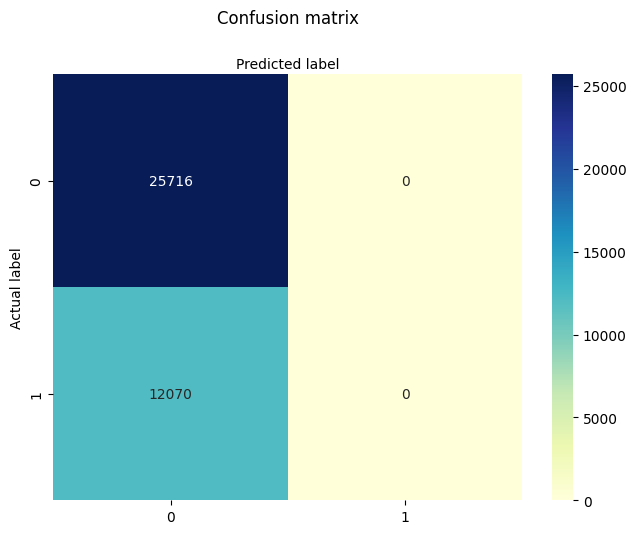

In [32]:


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

